In [ ]:
# import libraries
import time
import pandas as pd
from PIL import Image
from tqdm import tqdm
!pip install cfscrape -qq
import cfscrape #pip install cfscrape
scraper = cfscrape.create_scraper()

In [ ]:
from bs4 import BeautifulSoup
url = 'https://www.rightmove.co.uk/property-to-rent/find.html?locationIdentifier=REGION%5E87490&index=24&propertyTypes=&includeLetAgreed=false&mustHave=&dontShow=&furnishTypes=&keywords='

In [ ]:
import requests
html_content = scraper.get(url).text

# Parse the HTML content using Beautiful Soup
soup = BeautifulSoup(html_content, 'html.parser')

In [ ]:
all_links = [prop['id'][4:] for prop in soup.find_all('a', class_ = 'propertyCard-anchor')]
all_links

['136341743',
 '137250887',
 '137863259',
 '137874314',
 '137874242',
 '137550914',
 '137874221',
 '137874206',
 '137171273',
 '137874203',
 '137874200',
 '137874197',
 '137874185',
 '137874167',
 '137874089',
 '137873813',
 '137873816',
 '137873804',
 '137873792',
 '137873738',
 '137873687',
 '137873654',
 '136014002',
 '137873045',
 '137873585']

In [ ]:
for page in tqdm(range(24,900,24)):
    url = f'https://www.rightmove.co.uk/property-to-rent/find.html?locationIdentifier=REGION%5E87490&index={page}&propertyTypes=&includeLetAgreed=false&mustHave=&dontShow=&furnishTypes=&keywords='
    html_content = scraper.get(url).text

    # Parse the HTML content using Beautiful Soup
    soup = BeautifulSoup(html_content, 'html.parser')

    page_links = [prop['id'][4:] for prop in soup.find_all('a', class_ = 'propertyCard-anchor')]
    all_links += page_links

100%|██████████| 37/37 [00:41<00:00,  1.13s/it]


In [ ]:
all_specs = []
for link in tqdm(all_links):
    url = f'https://www.rightmove.co.uk/properties/{link}#/?channel=RES_LET'

    page = scraper.get(url)
    time.sleep(0.5)
    html_content = page.text
    soup = BeautifulSoup(html_content, 'html.parser')
    spec_dict = {}
    spec_dict['Address'] = soup.find(itemprop = 'streetAddress').text
    spec_dict['Price'] = soup.find(class_ = '_1gfnqJ3Vtd1z40MlC0MzXu').find('span').text

    for letting_detail in soup.find(class_ = '_2E1qBJkWUYMJYHfYJzUb_r').find_all(class_ = '_2RnXSVJcWbWv4IpBC1Sng6'):
        feature = letting_detail.find('dt').text.split(':')[0]
        value =  letting_detail.find('dd').text
        spec_dict[feature] = value
    spec_dict['description'] = soup.find(class_ = 'STw8udCxUaBUMfOOZu0iL _3nPVwR0HZYQah5tkVJHFh5').text
    try:
      spec_dict['features']= ', '.join([kk.text for kk in soup.find(class_ = '_1uI3IvdF5sIuBtRIvKrreQ').find_all('li')])
    except:
      pass
    all_specs.append(spec_dict)

100%|██████████| 950/950 [31:21<00:00,  1.98s/it]


In [ ]:
df = pd.DataFrame.from_dict(all_specs, orient='columns')
df.to_csv('rightmove.csv', index = False)
df

,Address,Price,Let available date,Deposit,Min. Tenancy,Let type,Furnish type,Council Tax,description,features
0,"Grosvenor Studios, Maybury Gardens, London, NW10","£1,750 pcm",19/08/2023,£0A deposit provides security for a landlord a...,Ask agent,Long term,"Furnished or unfurnished, landlord is flexible",Ask agent,A recently refurbished first floor apartment l...,"One Bedroom Flat, Available 19th August 2023, ..."
1,"Putney High Street, London","£3,100 pcm",07/08/2023,Ask agentA deposit provides security for a lan...,Ask agent,Long term,Furnished,Ask agent,Holding Deposit: £738.46SUMMARYCALLING ALL SHA...,"Furnished , Three Double Bedrooms , Open Plan ..."
2,"Great Ormond Street, London, WC1N","£2,975 pcm",31/07/2023,"£3,432A deposit provides security for a landlo...",Ask agent,Long term,"Furnished or unfurnished, landlord is flexible",Ask agent,This is a newly refurbished fourth floor (no l...,"Newly Refurbished 4th Floor Flat (No Lift), Bl..."
3,Markham Square Chelsea SW3,"£2,925 pcm",22/09/2023,Ask agentA deposit provides security for a lan...,Ask agent,Long term,Unfurnished,Ask agent,A bright and fresh first floor apartment with ...,"First floor apartment , Private front balcony,..."
4,"The Avenue, Ealing","£1,699 pcm",Ask agent,Ask agentA deposit provides security for a lan...,Ask agent,Long term,Furnished,Ask agent,An exceptional 772 sq ft one double bedroom ga...,"Church Conversion, One Bedroom, Patio Garden, ..."
...,...,...,...,...,...,...,...,...,...,...
945,"Dore Avenue, London, E12","£1,300 pcm",05/08/2023,Ask agentA deposit provides security for a lan...,Ask agent,Long term,Part furnished,Ask agent,One bedroom 2nd floor purpose built flat in pr...,NaN
946,"Jodrell Road, London, E3","£3,750 pcm",04/08/2023,Ask agentA deposit provides security for a lan...,Ask agent,Long term,"Furnished or unfurnished, landlord is flexible",Ask agent,"Delightful three double bedroom, two bathroom ...",NaN
947,"Anglo Road, London, E3","£3,850 pcm",Ask agent,Ask agentA deposit provides security for a lan...,Ask agent,NaN,"Furnished or unfurnished, landlord is flexible",Ask agent,This property comprises:\r - Spacious 4 Doubl...,"4 Bedrooms, 2 Bathroom, Separate Lounge, Fitte..."
948,"The Water Tower, Lamb Brewery Studios, Chiswic...","£5,000 pcm",01/08/2023,"£5,769A deposit provides security for a landlo...",Ask agent,Long term,Furnished,Ask agent,This stunning and truly unique penthouse apart...,"Unique Penthouse Apartment, Split Oer Three Fl..."


In [ ]:
# get competition "All competition" button
elem = driver.find_element(by=By.XPATH, value='//*[@id="site-content"]/div[4]/div[4]/div/div[2]/div/button[1]')
# button click
elem.click()
# javascript is running, so wait until to get the information.
time.sleep(5)

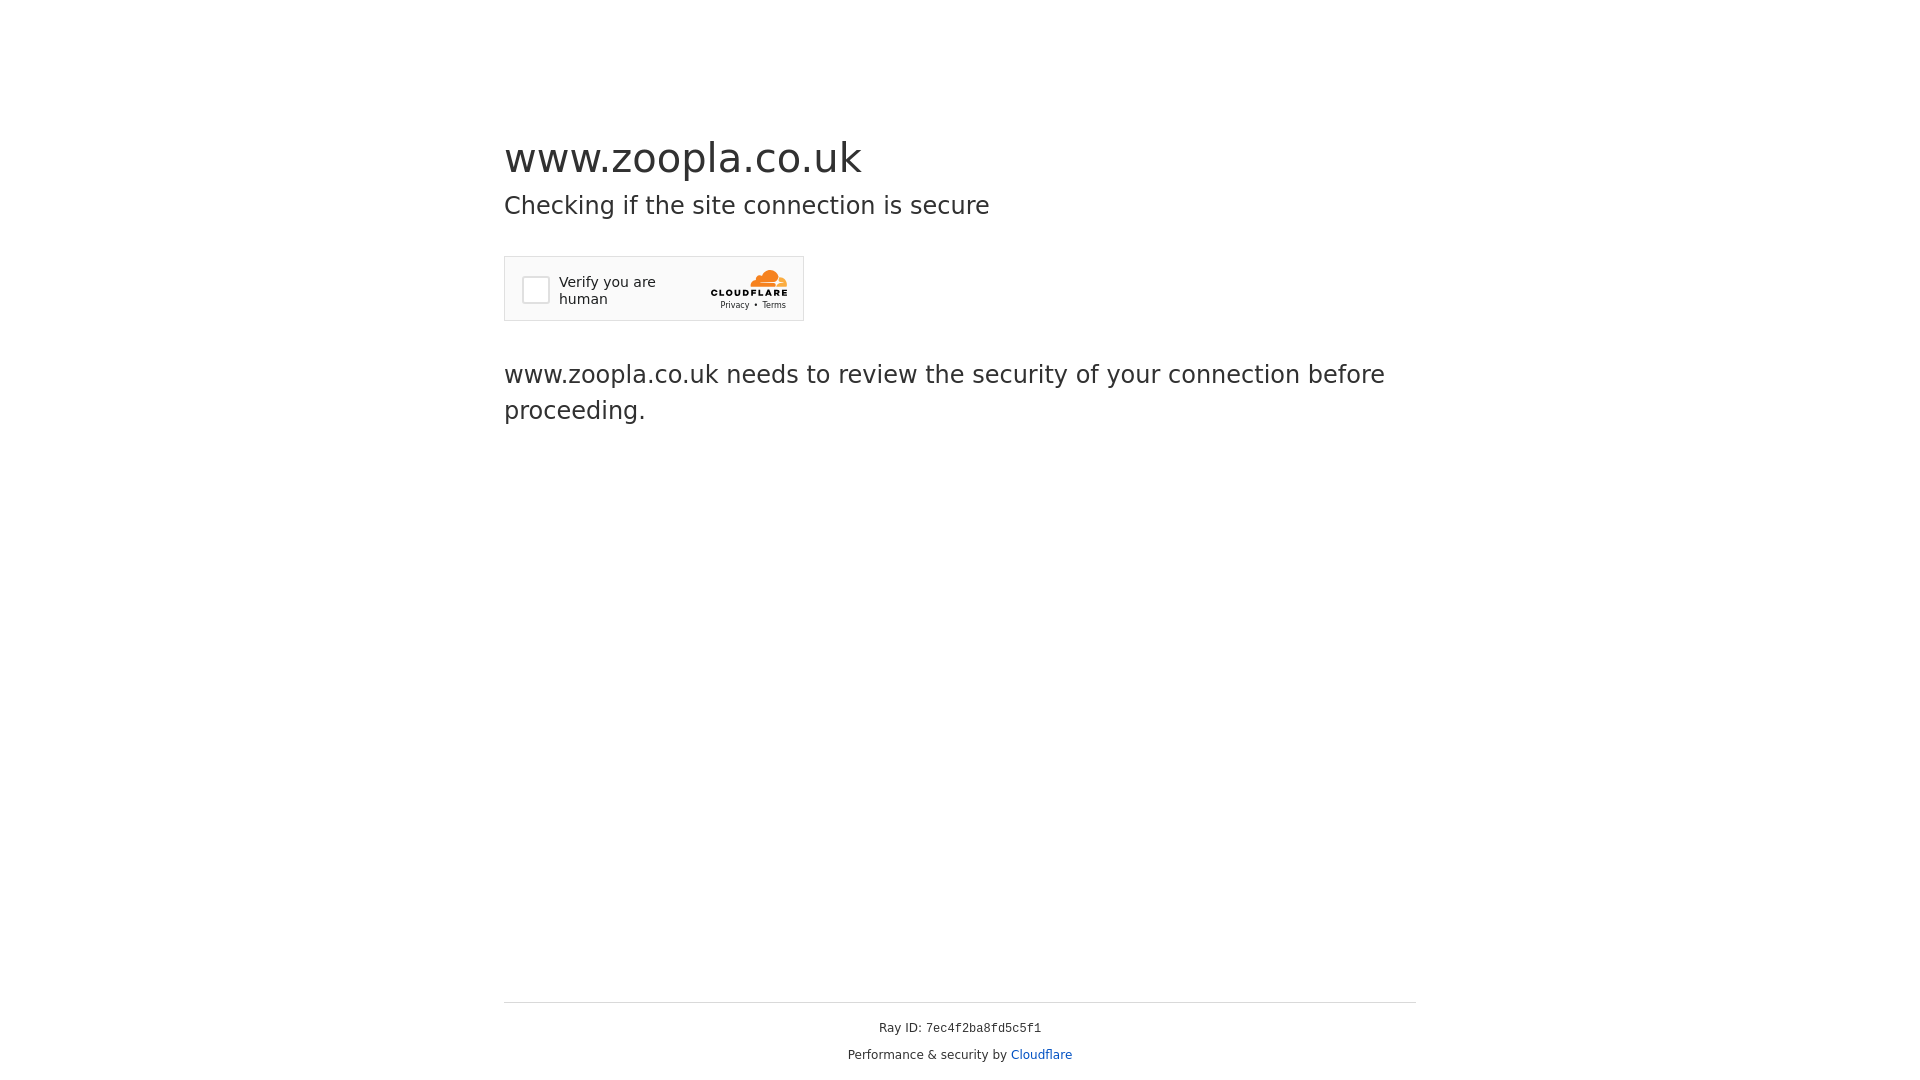

In [ ]:
# take a picture
driver.save_screenshot('result.png')
img = Image.open('result.png')
img